In [1]:
import os, shutil

In [2]:
ls ../../data

sample/


In [3]:
test_dir = '/Volumes/kenta/datasets/cancer/test_class'

base_dir = '../../data/sample/'

train_dir = os.path.join(base_dir, 'train/')

validation_dir = os.path.join(base_dir, 'validation/')

train_type_1 = os.path.join(train_dir, 'Type_1')

train_type_2 = os.path.join(train_dir, 'Type_2')

train_type_3 = os.path.join(train_dir, 'Type_3')

validation_type_1 = os.path.join(validation_dir, 'Type_1')

validation_type_2 = os.path.join(validation_dir, 'Type_2')

validation_type_3 = os.path.join(validation_dir, 'Type_3')

In [45]:
from keras import layers
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers.advanced_activations import ELU
elu = ELU(alpha=1.0)

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), input_shape=(64, 64, 3)))
model.add(elu)
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3)))
model.add(elu)
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3)))
model.add(elu)
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3)))
model.add(elu)
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.7))
model.add(layers.Dense(512))
model.add(elu)
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4), 
              metrics=['acc'], callbacks=[es])

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
elu_1 (ELU)                  multiple                  0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
elu_1 (ELU)                  multiple                  0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 128)       73856     
__________

In [48]:
from keras.preprocessing.image import ImageDataGenerator


# data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest')

# validation data should not be augmented 
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(64, 64), # all images will be resize to 64 * 64, 
        batch_size=20, 
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( 
        validation_dir, 
        target_size=(64, 64), 
        batch_size=20, 
        class_mode='categorical')


Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [9]:
for data_batch, labels_batch in train_generator:
    print('data batch:', data_batch.shape)
    print('labels batch:', labels_batch.shape)
    break

data batch: (20, 64, 64, 3)
labels batch: (20, 3)


In [10]:
for i in validation_generator:
    print(type(i))
    break

<class 'tuple'>


In [11]:
# code below is for reading images smoothly without generating warnings
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [12]:
for data_batch, labels_batch in validation_generator:
    print('data batch:', data_batch.shape)
    print('labels batch:', labels_batch.shape)
    break

data batch: (20, 64, 64, 3)
labels batch: (20, 3)


In [49]:
history = model.fit_generator(
      train_generator,  
      steps_per_epoch=600//20, #  it will take 30 batches to see 600 samples since each batch size is 20
      epochs=30, 
      validation_data=validation_generator, 
      validation_steps=150//20) # it will take 7.5 batches to see 150 validation samples since each batch size is 20

/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/30
30/30 [==============================] - 476s - loss: 1.1056 - acc: 0.3783 - val_loss: 1.0788 - val_acc: 0.4143

In [52]:
model.save("simple_conv2d_elu.h5")

ValueError: Unable to create group (Name already exists)

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

# Two graphs below shows no indication of overfitting

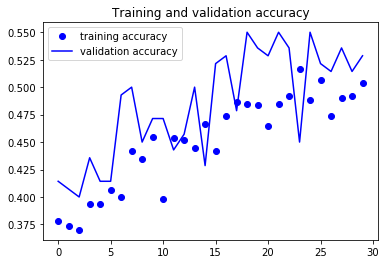

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title("Training and validation accuracy")
plt.legend()

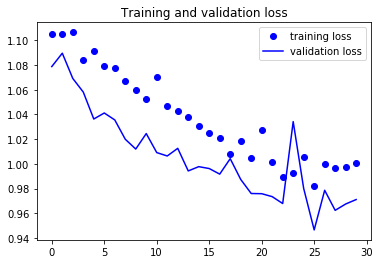

In [55]:
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title("Training and validation loss")
plt.legend()

In [56]:
path = '/Volumes/kenta/datasets/cancer/'
import pandas as pd
from glob import glob
import cv2
import numpy as np

In [57]:
sample_subm = pd.read_csv(path + '/sample_submission.csv')
sample_subm.head(n=3)

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.168805,0.527346,0.303849
1,1.jpg,0.168805,0.527346,0.303849
2,2.jpg,0.168805,0.527346,0.303849


In [58]:
ids = sample_subm['image_name'].values
len(ids)

512

In [59]:
ids[:3]

array(['0.jpg', '1.jpg', '2.jpg'], dtype=object)

In [60]:
test_path = '/Volumes/kenta/datasets/cancer/test/'

In [61]:
test_dir = '/Volumes/kenta/datasets/cancer/test_class/test/'

In [62]:
print(len(os.listdir(test_dir)))

512


# make a prediction for each sample on the test set  and
# save to the csv file called "sum.csv"

In [63]:
for num in ids:
    print("Predict for image {}".format(num))
    files = glob(test_dir + num)
    image_list = []

    for f in files:
        image = cv2.imread(f)
        image = cv2.resize(image, (64,64))
        image = image.astype('float32') // 255
        image_list.append(image)
        
    image_list = np.array(image_list)
    
    predictions = model.predict(image_list, verbose=1, batch_size=1)
    
    sample_subm.loc[sample_subm['image_name'] == num , 'Type_1'] = predictions[0,0]
    sample_subm.loc[sample_subm['image_name'] == num , 'Type_2'] = predictions[0,1]
    sample_subm.loc[sample_subm['image_name'] == num , 'Type_3'] = predictions[0,2]
    
    
sample_subm.to_csv("conv2d_elu_2.csv", index=False)

Predict for image 0.jpg
1/1 [==============================] - 0s

/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))



Predict for image 1.jpg
1/1 [==============================] - 0s
Predict for image 2.jpg
1/1 [==============================] - 0s
Predict for image 3.jpg
1/1 [==============================] - 0s
Predict for image 4.jpg
1/1 [==============================] - 0s
Predict for image 5.jpg
1/1 [==============================] - 0s
Predict for image 6.jpg
1/1 [==============================] - 0s
Predict for image 7.jpg
1/1 [==============================] - 0s
Predict for image 8.jpg
1/1 [==============================] - 0s
Predict for image 9.jpg
1/1 [==============================] - 0s
Predict for image 10.jpg
1/1 [==============================] - 0s
Predict for image 11.jpg
1/1 [==============================] - 0s
Predict for image 12.jpg
1/1 [==============================] - 0s
Predict for image 13.jpg
1/1 [==============================] - 0s
Predict for image 14.jpg
1/1 [==============================] - 0s
Predict for image 15.jpg
1/1 [==============================] - 0s
Pre

In [64]:
import pandas as pd
subm = pd.read_csv("conv2d_elu_2.csv")

In [65]:
subm.head(n=100)

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.256156,0.318731,0.425113
1,1.jpg,0.288056,0.308625,0.403319
2,2.jpg,0.256156,0.318731,0.425113
3,3.jpg,0.256156,0.318731,0.425113
4,4.jpg,0.474383,0.315305,0.210312
5,5.jpg,0.256156,0.318731,0.425113
6,6.jpg,0.456193,0.341592,0.202214
7,7.jpg,0.256156,0.318731,0.425113
8,8.jpg,0.342950,0.341545,0.315505
9,9.jpg,0.384655,0.324885,0.290461
